# AI Engineering Challenge

Task: find the model for prediction of the number of accidents for the given data.

Work plan:
1. Study the general information from the dataframe.
2. Conduct preprocessing of the data.
3. Determine models that can be used for this task.
4. Find optimal hyperparameters for the models.
5. Select the best model according to RMSE metric and validate it on a test sample.

<a id="0"></a> <br>
# Table of Contents  
1. [Data preprocessing](#1)     
2. [Model building and training](#2)
3. [Conclusion](#3)

<a id="1"></a>
## Data preprocessing
[Back to the top](#0)

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import randint
from sklearn.base import BaseEstimator, TransformerMixin
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
from hyperopt import hp, tpe, fmin, space_eval


In [4]:
df = pd.read_csv("monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv")
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN


Filter the data:
1) Category: 'Alkoholunfälle';
2) Type: 'insgesamt'.

In [5]:
filtered_df = df[(df['MONATSZAHL'] == 'Alkoholunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt')]
filtered_df[(filtered_df['MONATSZAHL'] != 'Alkoholunfälle') | (filtered_df['AUSPRAEGUNG'] != 'insgesamt')].shape[0]

0

Get rid of unuseful features

In [6]:
filtered_df = filtered_df[['JAHR', 'MONAT', 'WERT']]
filtered_df.head()

,JAHR,MONAT,WERT
0,2024,202401,NaN
1,2024,202402,NaN
2,2024,202403,NaN
3,2024,202404,NaN
4,2024,202405,NaN


In [7]:
filtered_df.dtypes

,0
JAHR,int64
MONAT,object
WERT,float64


In [8]:
filtered_df[~filtered_df['MONAT'].str.isnumeric()]

,JAHR,MONAT,WERT
24,2022,Summe,493.0
37,2021,Summe,383.0
50,2020,Summe,430.0
63,2019,Summe,434.0
76,2018,Summe,398.0
89,2017,Summe,409.0
102,2016,Summe,301.0
115,2015,Summe,411.0
128,2014,Summe,382.0
141,2013,Summe,377.0


Remove non-numerical data in column `MONAT`

In [9]:
filtered_df = filtered_df[filtered_df['MONAT'] != "Summe"]

In [10]:
filtered_df[~filtered_df['MONAT'].str.isnumeric()].shape[0]

0

In [11]:
filtered_df['MONAT'] = filtered_df['MONAT'].astype('int64')

<ipython-input-11-f233f7cd1d66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['MONAT'] = filtered_df['MONAT'].astype('int64')


In [12]:
filtered_df.dtypes

,0
JAHR,int64
MONAT,int64
WERT,float64


Add predicted instance (Year: '2021', Month: '01) to the training dataset in order to get lag features for it.

In [13]:
df_test = filtered_df[filtered_df['MONAT'] == 202101]
df_test

,JAHR,MONAT,WERT
38,2021,202101,16.0


In [14]:
filtered_df = filtered_df[filtered_df['JAHR'] <= 2020]
filtered_df = pd.concat([df_test, filtered_df], ignore_index=True, axis=0)

In [15]:
filtered_df.sort_values(by='JAHR', ascending=False).head(10)

,JAHR,MONAT,WERT
0,2021,202101,16.0
7,2020,202007,58.0
12,2020,202012,13.0
11,2020,202011,23.0
10,2020,202010,34.0
9,2020,202009,46.0
8,2020,202008,46.0
1,2020,202001,28.0
6,2020,202006,49.0
4,2020,202004,26.0


Check that there are no undefined values in dataset.

In [16]:
filtered_df.isna().mean()

,0
JAHR,0.0
MONAT,0.0
WERT,0.0


Create date index

In [17]:
filtered_df['MONAT'] = filtered_df['MONAT'] % 100
filtered_df.head()

,JAHR,MONAT,WERT
0,2021,1,16.0
1,2020,1,28.0
2,2020,2,40.0
3,2020,3,27.0
4,2020,4,26.0


In [18]:
filtered_df['Date'] = pd.to_datetime(filtered_df['JAHR'].astype(str) + filtered_df['MONAT'].astype(str), format='%Y%m')
filtered_df.head()

,JAHR,MONAT,WERT,Date
0,2021,1,16.0,2021-01-01
1,2020,1,28.0,2020-01-01
2,2020,2,40.0,2020-02-01
3,2020,3,27.0,2020-03-01
4,2020,4,26.0,2020-04-01


In [19]:
filtered_df = filtered_df.sort_values(by='Date')
filtered_df = filtered_df.reset_index(drop=True)
filtered_df.head()

,JAHR,MONAT,WERT,Date
0,2000,1,78.0,2000-01-01
1,2000,2,53.0,2000-02-01
2,2000,3,73.0,2000-03-01
3,2000,4,78.0,2000-04-01
4,2000,5,96.0,2000-05-01


In [20]:
filtered_df.set_index('Date', inplace=True)
filtered_df.head()

,JAHR,MONAT,WERT
Date,,,
2000-01-01,2000,1,78.0
2000-02-01,2000,2,53.0
2000-03-01,2000,3,73.0
2000-04-01,2000,4,78.0
2000-05-01,2000,5,96.0


Save filtered dataset for deployment

In [21]:
filtered_df.to_csv('app_data.csv')

Decompose data into seasonal and trend components

In [22]:
decomposed = seasonal_decompose(filtered_df["2000-01-01":"2020-12-01"]['WERT'], model='additive')

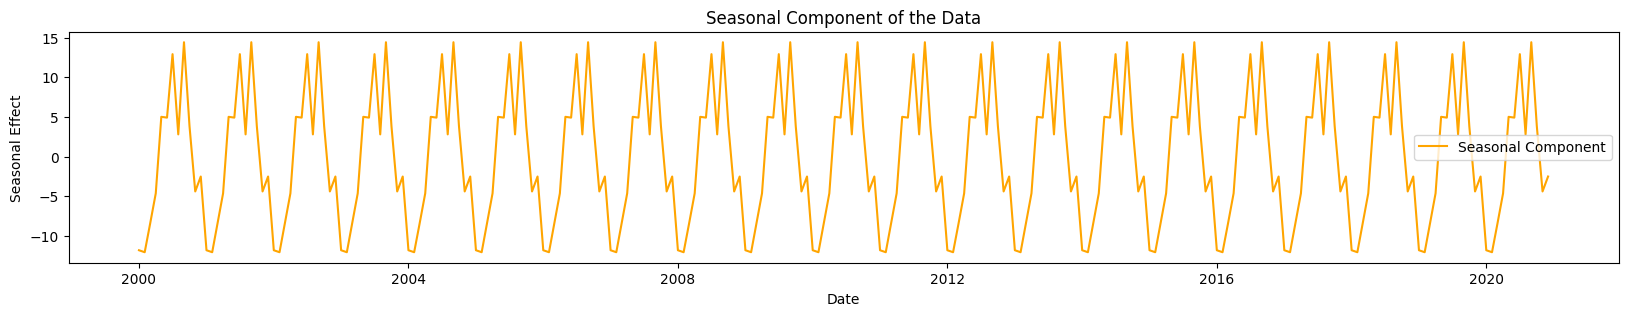

In [23]:
plt.figure(figsize=(20, 3))
plt.plot(decomposed.seasonal, label='Seasonal Component', color='orange')
plt.title('Seasonal Component of the Data')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.legend()
plt.show()

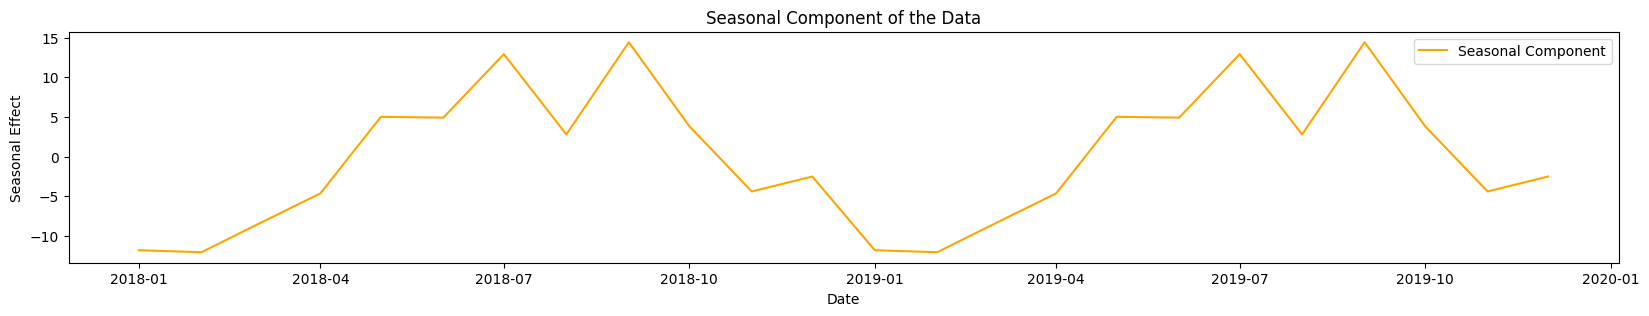

In [24]:
plt.figure(figsize=(20, 3))
plt.plot(decomposed.seasonal["2018-01-01":"2019-12-01"], label='Seasonal Component', color='orange')
plt.title('Seasonal Component of the Data')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.legend()
plt.show()

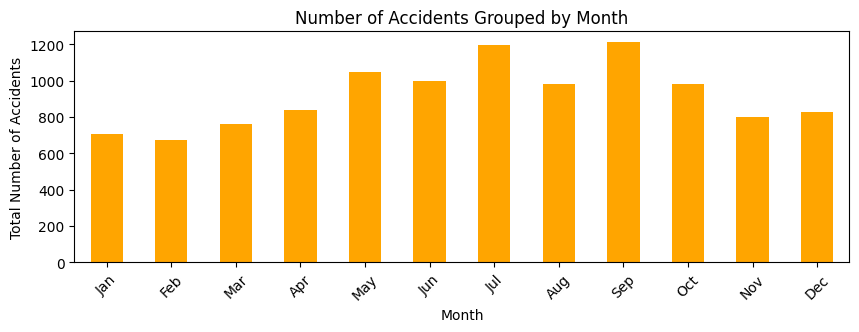

In [25]:
monthly_accidents = filtered_df["2000-01-01":"2020-12-01"].groupby(filtered_df["2000-01-01":"2020-12-01"].index.month)['WERT'].sum()
plt.figure(figsize=(10, 3))
monthly_accidents.plot(kind='bar', color='orange')
plt.title('Number of Accidents Grouped by Month')
plt.xlabel('Month')
plt.ylabel('Total Number of Accidents')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

The chart and plot indicate that the number of accidents tends to be higher in the summer and fall months and slightly lower during the winter months. Winter (December to February) typically experiences colder weather, which can lead to slick roads due to ice or snow, but these months tend to have fewer vehicles on the road due to holidays and people staying indoors. Although dangerous, fewer accidents might occur due to reduced driving. At the same time, summer months (June to August) experience warmer weather and longer daylight hours, which generally lead to more cars on the road, increasing the risk of accidents.

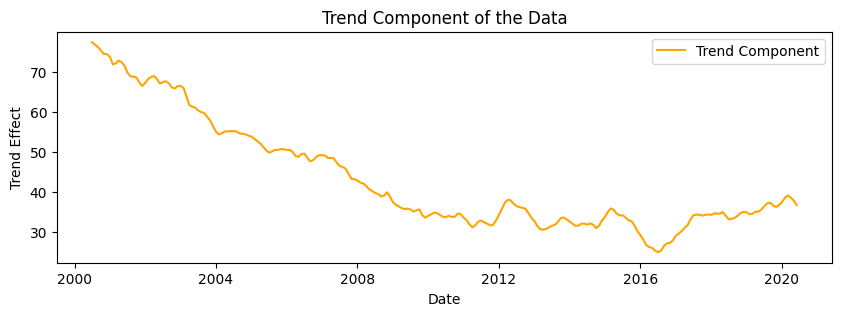

In [26]:
plt.figure(figsize=(10, 3))
plt.plot(decomposed.trend, label='Trend Component', color='orange')
plt.title('Trend Component of the Data')
plt.xlabel('Date')
plt.ylabel('Trend Effect')
plt.legend()
plt.show()

The overall trend indicates a decline in accidents, which could suggest improvements in traffic safety or public health initiatives.

Add the lag columns to the table, which indicate the size of the delay, and add the moving average as a feature rolling_mean. Adding these features are important because they help models identify the relationship between the current value of the series and its past values.

In [27]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data["lag_{}".format(lag)] = data["WERT"].shift(lag)

    data["rolling_mean"] = data["WERT"].shift().rolling(rolling_mean_size).mean()

    return data

In [28]:
filtered_df = make_features(filtered_df, 12, 12)
filtered_df.head()

,JAHR,MONAT,WERT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,,
2000-01-01,2000,1,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,2000,2,53.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,2000,3,73.0,53.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,2000,4,78.0,73.0,53.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2000,5,96.0,78.0,73.0,53.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="2"></a>
## Model building and training
[Back to the top](#0)

The following models will be built to solve the regression problem:
- LinearRegression;
- DecisionTreeRegressor;
- RandomForestRegressor;
- LSTM;
- Prophet.

Create train and test sets for the models.

In [29]:
train = filtered_df[filtered_df['JAHR'] < 2020]
train = train.dropna()
train

,JAHR,MONAT,WERT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,,
2001-01-01,2001,1,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,53.0,78.0,77.833333
2001-02-01,2001,2,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,53.0,76.833333
2001-03-01,2001,3,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,76.500000
2001-04-01,2001,4,68.0,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,75.666667
2001-05-01,2001,5,85.0,68.0,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,74.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,2019,8,31.0,48.0,40.0,39.0,36.0,34.0,28.0,22.0,21.0,31.0,43.0,36.0,40.0,34.833333
2019-09-01,2019,9,47.0,31.0,48.0,40.0,39.0,36.0,34.0,28.0,22.0,21.0,31.0,43.0,36.0,34.083333
2019-10-01,2019,10,45.0,47.0,31.0,48.0,40.0,39.0,36.0,34.0,28.0,22.0,21.0,31.0,43.0,35.000000


In [31]:
test = filtered_df[filtered_df['JAHR'] >= 2020]
test

,JAHR,MONAT,WERT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,,
2020-01-01,2020,1,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.0,34.0,28.0,22.0,36.166667
2020-02-01,2020,2,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.0,34.0,28.0,36.666667
2020-03-01,2020,3,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.0,34.0,37.666667
2020-04-01,2020,4,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.0,37.083333
2020-05-01,2020,5,40.0,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.250000
2020-06-01,2020,6,49.0,40.0,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,36.333333
2020-07-01,2020,7,58.0,49.0,40.0,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,37.083333
2020-08-01,2020,8,46.0,58.0,49.0,40.0,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,37.916667
2020-09-01,2020,9,46.0,46.0,58.0,49.0,40.0,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,39.166667


In [33]:
features_train = train.drop("WERT", axis=1)
target_train = train["WERT"]
features_test = test.drop("WERT", axis=1)
target_test = test["WERT"]

In [34]:
features_train.shape

(228, 15)

In [35]:
features_train.head()

,JAHR,MONAT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,
2001-01-01,2001,1,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,53.0,78.0,77.833333
2001-02-01,2001,2,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,53.0,76.833333
2001-03-01,2001,3,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,73.0,76.500000
2001-04-01,2001,4,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,78.0,75.666667
2001-05-01,2001,5,68.0,63.0,49.0,66.0,85.0,71.0,83.0,84.0,77.0,99.0,57.0,96.0,74.833333


In [36]:
features_test.shape

(13, 15)

In [37]:
features_test.head()

,JAHR,MONAT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,
2020-01-01,2020,1,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.0,34.0,28.0,22.0,36.166667
2020-02-01,2020,2,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.0,34.0,28.0,36.666667
2020-03-01,2020,3,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.0,34.0,37.666667
2020-04-01,2020,4,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.0,37.083333
2020-05-01,2020,5,26.0,27.0,40.0,28.0,35.0,29.0,45.0,47.0,31.0,48.0,40.0,39.0,36.250000


In [38]:
features_train_linear = features_train.copy()
features_test_linear = features_test.copy()

Scale features for the Linear Regression model.

In [39]:
numeric = features_train.columns.tolist()
scaler = StandardScaler()
scaler.fit(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train_linear[numeric] = scaler.transform(features_train[numeric])
features_test_linear[numeric] = scaler.transform(features_test[numeric])

In [40]:
features_train_linear.head()

,JAHR,MONAT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,
2001-01-01,-1.643168,-1.593255,2.516518,1.666840,2.337253,2.357048,1.928021,3.106577,0.749128,2.864233,1.851933,1.562477,0.471484,1.809537,2.471349
2001-02-01,-1.643168,-1.303572,1.388926,2.493784,1.636999,2.299405,2.328636,1.874362,3.098831,0.721841,2.833634,1.833881,1.558425,0.456301,2.399209
2001-03-01,-1.643168,-1.013890,0.380029,1.371504,2.453962,1.607687,2.271405,2.266430,1.868034,3.029032,0.706615,2.810935,1.830160,1.538890,2.375163
2001-04-01,-1.643168,-0.724207,1.210886,0.367358,1.345226,2.414691,1.584637,2.210421,2.259651,1.820503,2.997251,0.693985,2.808406,1.809537,2.315047
2001-05-01,-1.643168,-0.434524,1.507620,1.194301,0.353199,1.319472,2.385866,1.538303,2.203706,2.205035,1.797394,2.973778,0.688872,2.783866,2.254931


In [41]:
features_test_linear.head()

,JAHR,MONAT,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Date,,,,,,,,,,,,,,,
2020-01-01,1.825742,-1.593255,-0.450828,-0.813990,0.119780,0.224252,-0.704590,0.250079,-0.201943,-0.266956,-0.438704,-0.554473,-0.887191,-1.221710,-0.534453
2020-02-01,1.825742,-1.303572,-0.866257,-0.459586,-0.813892,0.108966,0.211101,-0.702087,0.245620,-0.212023,-0.275087,-0.445912,-0.561109,-0.896934,-0.498383
2020-03-01,1.825742,-1.013890,-0.154094,-0.873058,-0.463765,-0.813324,0.096640,0.194069,-0.705451,0.227442,-0.220548,-0.283070,-0.452415,-0.572157,-0.426244
2020-04-01,1.825742,-0.724207,-0.925604,-0.164249,-0.872247,-0.467466,-0.819051,0.082049,0.189674,-0.706421,0.215764,-0.228789,-0.289374,-0.463899,-0.468325
2020-05-01,1.825742,-0.434524,-0.984951,-0.932125,-0.171992,-0.870968,-0.475667,-0.814107,0.077784,0.172509,-0.711399,0.205458,-0.235027,-0.301510,-0.528441


In [42]:
features_test_linear.to_csv('app_data.csv')

Train models

In [43]:
%%time
model = LinearRegression()
time_split = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(
    model, features_train_linear, target_train, scoring='neg_root_mean_squared_error', cv=time_split, n_jobs=-1
)
print("RMSE of linear regression model on training set:", (scores * (-1)).min())

RMSE of linear regression model on training set: 8.46189268949064
CPU times: user 114 ms, sys: 131 ms, total: 245 ms
Wall time: 4.9 s


In [44]:
RANDOM_STATE = 12345

In [45]:
%%time
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {"max_depth": range(1, 11, 1)}
grid_tr = GridSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_tr.fit(features_train, target_train)
print(
    "Best hyperparameters for Decision Tree on the training set:",
    grid_tr.best_params_,
)
print(
    "RMSE of Decision Tree on the training set:",
    (grid_tr.best_score_ * (-1)),
)

Best hyperparameters for Decision Tree on the training set: {'max_depth': 3}
RMSE of Decision Tree on the training set: 9.890330793066823
CPU times: user 97.9 ms, sys: 11.6 ms, total: 109 ms
Wall time: 913 ms


In [46]:
%%time
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {"max_depth": range(1, 11, 1)}
rand_tr = RandomizedSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
rand_tr.fit(features_train, target_train)
print(
    "Best hyperparameters for Decision Tree on the training set:",
    rand_tr.best_params_,
)
print(
    "RMSE of Decision Tree on the training set:",
    (rand_tr.best_score_ * (-1)),
)

Best hyperparameters for Decision Tree on the training set: {'max_depth': 3}
RMSE of Decision Tree on the training set: 9.890330793066823
CPU times: user 106 ms, sys: 2.23 ms, total: 108 ms
Wall time: 819 ms


In [47]:
%%time
model = RandomForestRegressor(random_state=RANDOM_STATE)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {"n_estimators": range(1, 50, 1)}
grid_rf = GridSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error')
grid_rf.fit(features_train, target_train)
print(
    "Best hyperparameters for Random Forest on the training set:",
    grid_rf.best_params_,
)
print(
    "RMSE of Random Forest on the training set:",
    (grid_rf.best_score_ * (-1)),
)

Best hyperparameters for Random Forest on the training set: {'n_estimators': 14}
RMSE of Random Forest on the training set: 9.218993945368492
CPU times: user 19.1 s, sys: 82.5 ms, total: 19.2 s
Wall time: 20.3 s


In [48]:
%%time
model = RandomForestRegressor(random_state=RANDOM_STATE)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {"n_estimators": range(1, 50, 1)}
rand_rf = RandomizedSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
rand_rf.fit(features_train, target_train)
print(
    "Best hyperparameters for Random Forest on the training set:",
    rand_rf.best_params_,
)
print(
    "RMSE of Random Forest on the training set:",
    (rand_rf.best_score_ * (-1)),
)

Best hyperparameters for Random Forest on the training set: {'n_estimators': 45}
RMSE of Random Forest on the training set: 9.336363125696023
CPU times: user 322 ms, sys: 8.19 ms, total: 330 ms
Wall time: 3.22 s


In [49]:
%%time
model = CatBoostRegressor(loss_function="RMSE")
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'depth' : range(1, 10, 1),
              'learning_rate' : [0.11, 0.12, 0.13],
              'iterations'    : [49, 50, 51]
              }
grid_CBR = GridSearchCV(model, param_grid = parameters, cv = time_split, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_CBR.fit(features_train, target_train, verbose = 10)
print(
    "Best hyperparameters for CatBoostRegressor on the training set:",
    grid_CBR.best_params_,
)
print(
    "RMSE of CatBoostRegressor on the training set:",
    (grid_CBR.best_score_ * (-1)),
)

0:	learn: 15.4552158	total: 48.1ms	remaining: 2.36s
10:	learn: 9.3756147	total: 58.2ms	remaining: 206ms
20:	learn: 7.5634913	total: 78.6ms	remaining: 108ms
30:	learn: 6.8436583	total: 84.7ms	remaining: 51.9ms
40:	learn: 6.3419234	total: 89.7ms	remaining: 19.7ms
49:	learn: 6.0278756	total: 95.4ms	remaining: 0us
Best hyperparameters for CatBoostRegressor on the training set: {'depth': 4, 'iterations': 50, 'learning_rate': 0.13}
RMSE of CatBoostRegressor on the training set: 9.383987755833404
CPU times: user 1.29 s, sys: 137 ms, total: 1.43 s
Wall time: 53.7 s


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [50]:
%%time
model = CatBoostRegressor(loss_function="RMSE")
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'depth' : range(1, 10, 1),
              'learning_rate' : [0.12, 0.13, 0.14],
              'iterations'    : [49, 50, 51]
              }
rand_CBR = RandomizedSearchCV(model, parameters, cv=time_split, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
rand_CBR.fit(features_train, target_train, verbose = 10)
print(
    "Best hyperparameters for CatBoostRegressor on the training set:",
    rand_CBR.best_params_,
)
print(
    "RMSE of CatBoostRegressor on the training set:",
    (rand_CBR.best_score_ * (-1)),
)

0:	learn: 15.4552158	total: 679us	remaining: 32.6ms
10:	learn: 9.3756147	total: 7.15ms	remaining: 24.7ms
20:	learn: 7.5634913	total: 13.3ms	remaining: 17.8ms
30:	learn: 6.8436583	total: 19.9ms	remaining: 11.5ms
40:	learn: 6.3419234	total: 25.4ms	remaining: 4.96ms
48:	learn: 6.0498152	total: 30.5ms	remaining: 0us
Best hyperparameters for CatBoostRegressor on the training set: {'learning_rate': 0.13, 'iterations': 49, 'depth': 4}
RMSE of CatBoostRegressor on the training set: 9.390690527168285
CPU times: user 224 ms, sys: 32.2 ms, total: 256 ms
Wall time: 5.64 s


In [51]:
%%time
model = lgb.LGBMRegressor(verbosity= -1)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'max_depth' : range(1, 10, 1),
              'learning_rate' : [0.12, 0.13, 0.14],
              'n_estimators'    : [103, 104, 105]
              }
grid_lgb = GridSearchCV(model, param_grid = parameters, cv = time_split, scoring='neg_root_mean_squared_error')
grid_lgb.fit(features_train, target_train)
print(
    "Best hyperparameters for LGBMRegressor on the training set:",
    grid_lgb.best_params_,
)
print(
    "RMSE of LGBMRegressor on the training set:",
    (grid_lgb.best_score_ * (-1)),
)

Best hyperparameters for LGBMRegressor on the training set: {'learning_rate': 0.13, 'max_depth': 2, 'n_estimators': 104}
RMSE of LGBMRegressor on the training set: 10.72279197780647
CPU times: user 8.94 s, sys: 300 ms, total: 9.24 s
Wall time: 10 s


In [52]:
%%time
model = lgb.LGBMRegressor(verbosity= -1)
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'max_depth' : range(1, 10, 1),
              'learning_rate' : [0.12, 0.13, 0.14],
              'n_estimators'    : [103, 104, 105]
              }
rand_lgb = RandomizedSearchCV(model, parameters, cv = time_split, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE)
rand_lgb.fit(features_train, target_train)
print(
    "Best hyperparameters for LGBMRegressor on the training set:",
    rand_lgb.best_params_,
)
print(
    "RMSE of LGBMRegressor on the training set:",
    (rand_lgb.best_score_ * (-1)),
)

Best hyperparameters for LGBMRegressor on the training set: {'n_estimators': 104, 'max_depth': 2, 'learning_rate': 0.12}
RMSE of LGBMRegressor on the training set: 10.81320340515529
CPU times: user 1.1 s, sys: 34.8 ms, total: 1.14 s
Wall time: 1.9 s


In [77]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(features_train)
X_test_scaled = scaler.transform(features_test)

In [78]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, target_train, test_size=0.2, shuffle=False)

In [129]:
def create_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    return model

scaler_X = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(features_train)
X_test_scaled = scaler_X.transform(features_test)

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [145]:
%%time
model = KerasRegressor(model=create_model, verbose=0, units=50, dropout_rate=0.2, learning_rate=0.001)

param_dist = {
    'units': [650],
    'dropout_rate': [0.3],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [300]
}

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

time_split = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5, cv=time_split, verbose=0, n_jobs=-1, random_state=RANDOM_STATE, scoring='neg_root_mean_squared_error')
random_search_result = random_search.fit(X_train_scaled, target_train, callbacks=[early_stopping])

best_model = random_search_result.best_estimator_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


CPU times: user 10min 9s, sys: 53.7 s, total: 11min 3s
Wall time: 1h 5min 9s


In [146]:
best_params = random_search_result.best_params_
print("Best model parameters:", best_params)

Best model parameters: {'units': 650, 'learning_rate': 0.001, 'epochs': 300, 'dropout_rate': 0.3, 'batch_size': 16}


In [147]:
print("RMSE of LSTM on the training set:", (random_search_result.best_score_ * (-1)))

RMSE of LSTM on the training set: 8.887394272419586


In [160]:
target_train_prophet = target_train.reset_index()
target_train_prophet['Date']

,Date
0,2001-01-01
1,2001-02-01
2,2001-03-01
3,2001-04-01
4,2001-05-01
...,...
223,2019-08-01
224,2019-09-01
225,2019-10-01
226,2019-11-01


In [161]:
target_train_prophet.columns = ['ds', 'y']
target_train_prophet

,ds,y
0,2001-01-01,66.0
1,2001-02-01,49.0
2,2001-03-01,63.0
3,2001-04-01,68.0
4,2001-05-01,85.0
...,...,...
223,2019-08-01,31.0
224,2019-09-01,47.0
225,2019-10-01,45.0
226,2019-11-01,29.0


In [153]:
rmse_list = []

In [154]:
def objective(params):
    yearly_seasonality = params['yearly_seasonality']
    changepoint_prior_scale = params['changepoint_prior_scale']
    seasonality_prior_scale = params['seasonality_prior_scale']

    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores = []

    for train_index, val_index in tscv.split(target_train_prophet):
        train_fold = target_train_prophet.iloc[train_index]
        val_fold = target_train_prophet.iloc[val_index]

        model = Prophet(
            yearly_seasonality=yearly_seasonality,
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )
        model.fit(train_fold)

        future = model.make_future_dataframe(len(val_fold), freq='MS')
        forecast = model.predict(future)

        rmse = np.sqrt(mean_squared_error(val_fold['y'], forecast['yhat'][:len(val_fold)]))
        rmse_scores.append(rmse)

    rmse_list.append(np.mean(rmse_scores))
    return np.mean(rmse_scores)

In [157]:
param_space = {
    'yearly_seasonality': hp.choice('yearly_seasonality', [True, False]),
    'changepoint_prior_scale': hp.uniform('changepoint_prior_scale', 0.01, 0.5),
    'seasonality_prior_scale': hp.uniform('seasonality_prior_scale', 5.0, 20.0),
}

In [162]:
%%time
best = fmin(fn=objective,
            space=param_space,
            algo=tpe.suggest,
            max_evals=100,
            rstate=np.random.default_rng(RANDOM_STATE))

print(f"Best Hyperparameters: {best}")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/hpwrprzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/5sk4onub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52445', 'data', 'file=/tmp/tmpvsrrfuy4/hpwrprzm.json', 'init=/tmp/tmpvsrrfuy4/5sk4onub.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelpcwthb7p/prophet_model-20241201203641.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:41 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:42 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

  1%|          | 1/100 [00:02<04:30,  2.73s/trial, best loss: 28.844775805626398]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/0s3loncp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/_yei12l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41972', 'data', 'file=/tmp/tmpvsrrfuy4/0s3loncp.json', 'init=/tmp/tmpvsrrfuy4/_yei12l3.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeltk8aee_6/prophet_model-20241201203643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:43 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:44 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

  2%|▏         | 2/100 [00:05<04:25,  2.70s/trial, best loss: 28.844775805626398]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/p1qrht2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/9a5yn2o5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24501', 'data', 'file=/tmp/tmpvsrrfuy4/p1qrht2j.json', 'init=/tmp/tmpvsrrfuy4/9a5yn2o5.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeli7beetb8/prophet_model-20241201203645.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:45 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

  3%|▎         | 3/100 [00:06<03:15,  2.01s/trial, best loss: 28.844775805626398]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/q1y44aoi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/85qdspsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6249', 'data', 'file=/tmp/tmpvsrrfuy4/q1y44aoi.json', 'init=/tmp/tmpvsrrfuy4/85qdspsc.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model2o52wtd4/prophet_model-20241201203647.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:47 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:47 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonal

  4%|▍         | 4/100 [00:08<03:19,  2.08s/trial, best loss: 28.844775805626398]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/9uibyyxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ffpsw_ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36887', 'data', 'file=/tmp/tmpvsrrfuy4/9uibyyxa.json', 'init=/tmp/tmpvsrrfuy4/ffpsw_ey.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelnx90ze87/prophet_model-20241201203649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:49 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:50 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

  5%|▌         | 5/100 [00:11<03:28,  2.19s/trial, best loss: 28.844775805626398]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/wr57xg07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/6u6xyv2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34643', 'data', 'file=/tmp/tmpvsrrfuy4/wr57xg07.json', 'init=/tmp/tmpvsrrfuy4/6u6xyv2l.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelf000saqq/prophet_model-20241201203651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:51 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:51 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

  6%|▌         | 6/100 [00:12<02:51,  1.82s/trial, best loss: 28.844775805626398]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/d2kd1uno.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/h2iw0qwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91950', 'data', 'file=/tmp/tmpvsrrfuy4/d2kd1uno.json', 'init=/tmp/tmpvsrrfuy4/h2iw0qwz.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelvsx_w9pq/prophet_model-20241201203652.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:52 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:53 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

  7%|▋         | 7/100 [00:14<02:48,  1.81s/trial, best loss: 28.844775805626398]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/yaudq9xv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/682t4_gy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74628', 'data', 'file=/tmp/tmpvsrrfuy4/yaudq9xv.json', 'init=/tmp/tmpvsrrfuy4/682t4_gy.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelarxsqift/prophet_model-20241201203654.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:54 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:55 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

  8%|▊         | 8/100 [00:16<02:59,  1.96s/trial, best loss: 28.844775805626398]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/u8e9lsdi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/459u9lhe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61979', 'data', 'file=/tmp/tmpvsrrfuy4/u8e9lsdi.json', 'init=/tmp/tmpvsrrfuy4/459u9lhe.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modellz4k34q5/prophet_model-20241201203656.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:56 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:57 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

  9%|▉         | 9/100 [00:17<02:48,  1.85s/trial, best loss: 28.834660110662433]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/gm2m0da8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/_48oc_0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82486', 'data', 'file=/tmp/tmpvsrrfuy4/gm2m0da8.json', 'init=/tmp/tmpvsrrfuy4/_48oc_0z.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model9bl2f3ml/prophet_model-20241201203658.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:58 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:36:58 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 10%|█         | 10/100 [00:19<02:38,  1.76s/trial, best loss: 28.834660110662433]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/kn1fgzxe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/9y6e88ll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70351', 'data', 'file=/tmp/tmpvsrrfuy4/kn1fgzxe.json', 'init=/tmp/tmpvsrrfuy4/9y6e88ll.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelc7hwsdtf/prophet_model-20241201203700.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:00 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:00 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 11%|█         | 11/100 [00:21<02:37,  1.77s/trial, best loss: 28.834660110662433]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/etyiveut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/uss5tvpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94178', 'data', 'file=/tmp/tmpvsrrfuy4/etyiveut.json', 'init=/tmp/tmpvsrrfuy4/uss5tvpz.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model4hvhj2ob/prophet_model-20241201203701.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:01 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:01 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 12%|█▏        | 12/100 [00:22<02:15,  1.55s/trial, best loss: 28.384972795203527]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/vu774eis.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/7rn37z9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33734', 'data', 'file=/tmp/tmpvsrrfuy4/vu774eis.json', 'init=/tmp/tmpvsrrfuy4/7rn37z9v.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model6i7qlfyw/prophet_model-20241201203702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:02 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:03 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 13%|█▎        | 13/100 [00:24<02:35,  1.79s/trial, best loss: 28.384972795203527]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/shg56i0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ys6tg6i9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16940', 'data', 'file=/tmp/tmpvsrrfuy4/shg56i0h.json', 'init=/tmp/tmpvsrrfuy4/ys6tg6i9.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelzmjzdqkp/prophet_model-20241201203705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:05 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 14%|█▍        | 14/100 [00:26<02:35,  1.80s/trial, best loss: 28.384972795203527]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/gkpazv1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ao6ff5o3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9811', 'data', 'file=/tmp/tmpvsrrfuy4/gkpazv1w.json', 'init=/tmp/tmpvsrrfuy4/ao6ff5o3.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeldhpcb2ai/prophet_model-20241201203707.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:07 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:07 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonal

 15%|█▌        | 15/100 [00:27<02:15,  1.60s/trial, best loss: 28.384972795203527]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ro01n4ye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/hgc8gj99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28199', 'data', 'file=/tmp/tmpvsrrfuy4/ro01n4ye.json', 'init=/tmp/tmpvsrrfuy4/hgc8gj99.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model5yw2fdy8/prophet_model-20241201203708.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:08 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:08 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 16%|█▌        | 16/100 [00:28<01:59,  1.42s/trial, best loss: 28.36377706423098] 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/1cdo34pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/zryld2n0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9222', 'data', 'file=/tmp/tmpvsrrfuy4/1cdo34pl.json', 'init=/tmp/tmpvsrrfuy4/zryld2n0.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model6m3h41oc/prophet_model-20241201203709.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:09 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:09 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonal

 17%|█▋        | 17/100 [00:30<02:07,  1.53s/trial, best loss: 28.36377706423098]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/2lnj3j9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/pn796dpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97933', 'data', 'file=/tmp/tmpvsrrfuy4/2lnj3j9k.json', 'init=/tmp/tmpvsrrfuy4/pn796dpj.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeluxp8qa9q/prophet_model-20241201203710.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:11 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:11 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 18%|█▊        | 18/100 [00:31<01:57,  1.43s/trial, best loss: 28.36377706423098]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/g8yihbyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/fx9xz2lp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74670', 'data', 'file=/tmp/tmpvsrrfuy4/g8yihbyo.json', 'init=/tmp/tmpvsrrfuy4/fx9xz2lp.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelsod78wo8/prophet_model-20241201203712.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:12 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:13 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 19%|█▉        | 19/100 [00:35<02:43,  2.02s/trial, best loss: 28.36377706423098]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/34urkbqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/9sqp1mlm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69768', 'data', 'file=/tmp/tmpvsrrfuy4/34urkbqy.json', 'init=/tmp/tmpvsrrfuy4/9sqp1mlm.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeljksb4_yo/prophet_model-20241201203715.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:15 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:16 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 20%|██        | 20/100 [00:37<03:02,  2.28s/trial, best loss: 28.36377706423098]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/71b12_g9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/clgdeo2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14315', 'data', 'file=/tmp/tmpvsrrfuy4/71b12_g9.json', 'init=/tmp/tmpvsrrfuy4/clgdeo2g.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelikl7sqsh/prophet_model-20241201203718.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:18 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:18 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 21%|██        | 21/100 [00:38<02:31,  1.92s/trial, best loss: 28.36377706423098]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/kdwsx4v4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/6cdo9v1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14278', 'data', 'file=/tmp/tmpvsrrfuy4/kdwsx4v4.json', 'init=/tmp/tmpvsrrfuy4/6cdo9v1g.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelink_1hyy/prophet_model-20241201203719.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:19 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:19 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 22%|██▏       | 22/100 [00:40<02:10,  1.68s/trial, best loss: 28.36377706423098]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/suey2dfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/9lhqpbud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16981', 'data', 'file=/tmp/tmpvsrrfuy4/suey2dfw.json', 'init=/tmp/tmpvsrrfuy4/9lhqpbud.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelz__iglnz/prophet_model-20241201203720.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:20 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 23%|██▎       | 23/100 [00:41<01:54,  1.49s/trial, best loss: 26.904679067910337]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/272cil9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/300sop2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53979', 'data', 'file=/tmp/tmpvsrrfuy4/272cil9k.json', 'init=/tmp/tmpvsrrfuy4/300sop2f.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelkk0xzo6l/prophet_model-20241201203721.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:21 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:21 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 24%|██▍       | 24/100 [00:42<01:43,  1.36s/trial, best loss: 26.904679067910337]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/edg36u_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/fdfdnnsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63230', 'data', 'file=/tmp/tmpvsrrfuy4/edg36u_2.json', 'init=/tmp/tmpvsrrfuy4/fdfdnnsu.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeldbz7n2gl/prophet_model-20241201203722.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:22 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:22 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 25%|██▌       | 25/100 [00:43<01:34,  1.25s/trial, best loss: 26.904679067910337]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/1ckylovp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/eie095kz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28141', 'data', 'file=/tmp/tmpvsrrfuy4/1ckylovp.json', 'init=/tmp/tmpvsrrfuy4/eie095kz.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelehbviyuw/prophet_model-20241201203723.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:23 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:23 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 26%|██▌       | 26/100 [00:44<01:26,  1.17s/trial, best loss: 26.904679067910337]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/1kfov5qk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/qm82np4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24025', 'data', 'file=/tmp/tmpvsrrfuy4/1kfov5qk.json', 'init=/tmp/tmpvsrrfuy4/qm82np4l.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelxyagrt_5/prophet_model-20241201203724.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:24 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 27%|██▋       | 27/100 [00:45<01:23,  1.15s/trial, best loss: 26.904679067910337]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/d0_dii79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/vznwljgs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37743', 'data', 'file=/tmp/tmpvsrrfuy4/d0_dii79.json', 'init=/tmp/tmpvsrrfuy4/vznwljgs.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modela5f7qb1j/prophet_model-20241201203725.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:25 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:26 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 28%|██▊       | 28/100 [00:46<01:24,  1.18s/trial, best loss: 26.904679067910337]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/5ne2pyr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/bfn9a8bu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67751', 'data', 'file=/tmp/tmpvsrrfuy4/5ne2pyr6.json', 'init=/tmp/tmpvsrrfuy4/bfn9a8bu.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelrwt5_ey_/prophet_model-20241201203727.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:27 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 29%|██▉       | 29/100 [00:47<01:24,  1.19s/trial, best loss: 26.5019825500724]  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/6cg3zqin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/kn_4dklf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99827', 'data', 'file=/tmp/tmpvsrrfuy4/6cg3zqin.json', 'init=/tmp/tmpvsrrfuy4/kn_4dklf.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelpmkse9wg/prophet_model-20241201203728.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:28 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 30%|███       | 30/100 [00:49<01:29,  1.28s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/pn39eagb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/tjr5inqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43600', 'data', 'file=/tmp/tmpvsrrfuy4/pn39eagb.json', 'init=/tmp/tmpvsrrfuy4/tjr5inqh.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelo9q7ovtc/prophet_model-20241201203729.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:29 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:30 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 31%|███       | 31/100 [00:50<01:34,  1.37s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/h06kwsys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/99xun46_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31679', 'data', 'file=/tmp/tmpvsrrfuy4/h06kwsys.json', 'init=/tmp/tmpvsrrfuy4/99xun46_.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelmramfwnq/prophet_model-20241201203731.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:31 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:31 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 32%|███▏      | 32/100 [00:52<01:33,  1.38s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/my23m8jb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ypx1w0ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12961', 'data', 'file=/tmp/tmpvsrrfuy4/my23m8jb.json', 'init=/tmp/tmpvsrrfuy4/ypx1w0ls.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelgbxd7p56/prophet_model-20241201203732.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:32 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 33%|███▎      | 33/100 [00:53<01:37,  1.45s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/96ebfllo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/9krpk5lh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37861', 'data', 'file=/tmp/tmpvsrrfuy4/96ebfllo.json', 'init=/tmp/tmpvsrrfuy4/9krpk5lh.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelz8e8n3x9/prophet_model-20241201203734.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:34 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:34 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 34%|███▍      | 34/100 [00:55<01:35,  1.45s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/6se6p2kv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/94x7ra7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43554', 'data', 'file=/tmp/tmpvsrrfuy4/6se6p2kv.json', 'init=/tmp/tmpvsrrfuy4/94x7ra7b.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelbvr1lk03/prophet_model-20241201203735.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:35 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 35%|███▌      | 35/100 [00:56<01:29,  1.37s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/2bsa1t3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ecaf7rcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76379', 'data', 'file=/tmp/tmpvsrrfuy4/2bsa1t3z.json', 'init=/tmp/tmpvsrrfuy4/ecaf7rcf.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelnxvocbgc/prophet_model-20241201203737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:37 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 36%|███▌      | 36/100 [00:57<01:21,  1.28s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/93y9lv46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/qpfgfotg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31138', 'data', 'file=/tmp/tmpvsrrfuy4/93y9lv46.json', 'init=/tmp/tmpvsrrfuy4/qpfgfotg.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modela73wwsf8/prophet_model-20241201203738.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:38 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:38 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 37%|███▋      | 37/100 [00:58<01:15,  1.20s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/6pf58m26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/hq0yr3ag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56371', 'data', 'file=/tmp/tmpvsrrfuy4/6pf58m26.json', 'init=/tmp/tmpvsrrfuy4/hq0yr3ag.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modell5jwcfo7/prophet_model-20241201203739.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:39 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 38%|███▊      | 38/100 [00:59<01:17,  1.25s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/_h6odde_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/9gmh9o65.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71514', 'data', 'file=/tmp/tmpvsrrfuy4/_h6odde_.json', 'init=/tmp/tmpvsrrfuy4/9gmh9o65.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelj_56t811/prophet_model-20241201203740.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:40 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:40 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 39%|███▉      | 39/100 [01:01<01:13,  1.21s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/kxzb33zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/p7y25lu3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31080', 'data', 'file=/tmp/tmpvsrrfuy4/kxzb33zk.json', 'init=/tmp/tmpvsrrfuy4/p7y25lu3.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model_7o6u6uf/prophet_model-20241201203741.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:41 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 40%|████      | 40/100 [01:02<01:20,  1.35s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/uej2mwvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/49of39_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69997', 'data', 'file=/tmp/tmpvsrrfuy4/uej2mwvb.json', 'init=/tmp/tmpvsrrfuy4/49of39_t.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model86kjwmac/prophet_model-20241201203743.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:43 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 41%|████      | 41/100 [01:03<01:17,  1.31s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/sqf5339w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/xnqe64gp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11008', 'data', 'file=/tmp/tmpvsrrfuy4/sqf5339w.json', 'init=/tmp/tmpvsrrfuy4/xnqe64gp.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeldzybd1tx/prophet_model-20241201203744.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:44 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 42%|████▏     | 42/100 [01:05<01:12,  1.25s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/tba_twba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/b767re2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60895', 'data', 'file=/tmp/tmpvsrrfuy4/tba_twba.json', 'init=/tmp/tmpvsrrfuy4/b767re2w.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelody4t66c/prophet_model-20241201203745.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:45 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:46 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 43%|████▎     | 43/100 [01:07<01:32,  1.62s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/c1xzl01p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/4t3egp0_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48676', 'data', 'file=/tmp/tmpvsrrfuy4/c1xzl01p.json', 'init=/tmp/tmpvsrrfuy4/4t3egp0_.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelzunqp_eu/prophet_model-20241201203748.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:48 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:48 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 44%|████▍     | 44/100 [01:09<01:31,  1.63s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ofwgexhn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ylu99_do.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66091', 'data', 'file=/tmp/tmpvsrrfuy4/ofwgexhn.json', 'init=/tmp/tmpvsrrfuy4/ylu99_do.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelov7c9m2p/prophet_model-20241201203749.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:49 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:49 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 45%|████▌     | 45/100 [01:11<01:32,  1.69s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/zyrky3k5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/omv3hlii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9600', 'data', 'file=/tmp/tmpvsrrfuy4/zyrky3k5.json', 'init=/tmp/tmpvsrrfuy4/omv3hlii.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelzo4uty_f/prophet_model-20241201203751.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:51 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonal

 46%|████▌     | 46/100 [01:13<01:47,  1.98s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/x_7p2kau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/pljmii0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39083', 'data', 'file=/tmp/tmpvsrrfuy4/x_7p2kau.json', 'init=/tmp/tmpvsrrfuy4/pljmii0m.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelmosu_iyx/prophet_model-20241201203754.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:54 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 47%|████▋     | 47/100 [01:14<01:30,  1.71s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/wjksf_9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/klyxu5ho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44187', 'data', 'file=/tmp/tmpvsrrfuy4/wjksf_9z.json', 'init=/tmp/tmpvsrrfuy4/klyxu5ho.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelu9drzja2/prophet_model-20241201203755.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:55 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 48%|████▊     | 48/100 [01:15<01:19,  1.52s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/d0rt0tx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/09s8avj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66514', 'data', 'file=/tmp/tmpvsrrfuy4/d0rt0tx9.json', 'init=/tmp/tmpvsrrfuy4/09s8avj4.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelt6tvt3lp/prophet_model-20241201203756.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:56 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:56 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 49%|████▉     | 49/100 [01:17<01:22,  1.62s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/xwjz9tpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/7h5dohts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33745', 'data', 'file=/tmp/tmpvsrrfuy4/xwjz9tpv.json', 'init=/tmp/tmpvsrrfuy4/7h5dohts.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelvbxz6nhs/prophet_model-20241201203758.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:58 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 50%|█████     | 50/100 [01:18<01:14,  1.49s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/_l8_ibog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/nmqyraw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92379', 'data', 'file=/tmp/tmpvsrrfuy4/_l8_ibog.json', 'init=/tmp/tmpvsrrfuy4/nmqyraw6.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelih0q0jm7/prophet_model-20241201203759.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:37:59 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 51%|█████     | 51/100 [01:20<01:18,  1.61s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/79fndc7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/2h1e0bj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21060', 'data', 'file=/tmp/tmpvsrrfuy4/79fndc7a.json', 'init=/tmp/tmpvsrrfuy4/2h1e0bj4.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model3odwk8ey/prophet_model-20241201203801.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:01 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:01 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 52%|█████▏    | 52/100 [01:21<01:10,  1.47s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/5r4r9pus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/jjx8erg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76076', 'data', 'file=/tmp/tmpvsrrfuy4/5r4r9pus.json', 'init=/tmp/tmpvsrrfuy4/jjx8erg0.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeljevqht8h/prophet_model-20241201203802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:02 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:02 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 53%|█████▎    | 53/100 [01:23<01:08,  1.46s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/vu09pep0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/nfncnw9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99163', 'data', 'file=/tmp/tmpvsrrfuy4/vu09pep0.json', 'init=/tmp/tmpvsrrfuy4/nfncnw9z.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelcc6juxs0/prophet_model-20241201203803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:03 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 54%|█████▍    | 54/100 [01:24<01:08,  1.49s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/o1mc0cnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/r6k18uhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65631', 'data', 'file=/tmp/tmpvsrrfuy4/o1mc0cnv.json', 'init=/tmp/tmpvsrrfuy4/r6k18uhz.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model_hf7hk9p/prophet_model-20241201203805.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:05 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:06 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 55%|█████▌    | 55/100 [01:27<01:18,  1.75s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/4t1pt_f3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/6lo0q2t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3188', 'data', 'file=/tmp/tmpvsrrfuy4/4t1pt_f3.json', 'init=/tmp/tmpvsrrfuy4/6lo0q2t0.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelalh_9y5e/prophet_model-20241201203807.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:07 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:08 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonal

 56%|█████▌    | 56/100 [01:28<01:15,  1.72s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/_6_28cyp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/2_8xt60c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46706', 'data', 'file=/tmp/tmpvsrrfuy4/_6_28cyp.json', 'init=/tmp/tmpvsrrfuy4/2_8xt60c.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model9kkea0mz/prophet_model-20241201203809.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:09 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:09 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 57%|█████▋    | 57/100 [01:30<01:12,  1.68s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/2a7_fm9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/pjkyw6qd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17983', 'data', 'file=/tmp/tmpvsrrfuy4/2a7_fm9d.json', 'init=/tmp/tmpvsrrfuy4/pjkyw6qd.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelbmub9kln/prophet_model-20241201203811.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:11 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:11 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 58%|█████▊    | 58/100 [01:32<01:13,  1.75s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/yand6f7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ka79pxxh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34933', 'data', 'file=/tmp/tmpvsrrfuy4/yand6f7k.json', 'init=/tmp/tmpvsrrfuy4/ka79pxxh.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelos7gxorh/prophet_model-20241201203812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:12 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:13 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 59%|█████▉    | 59/100 [01:33<01:04,  1.58s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/zxpldwsb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/kaeb07ek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98638', 'data', 'file=/tmp/tmpvsrrfuy4/zxpldwsb.json', 'init=/tmp/tmpvsrrfuy4/kaeb07ek.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelqhn0qj6t/prophet_model-20241201203814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:14 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:14 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 60%|██████    | 60/100 [01:34<00:57,  1.43s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/605i_ctr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/dcq8e093.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44062', 'data', 'file=/tmp/tmpvsrrfuy4/605i_ctr.json', 'init=/tmp/tmpvsrrfuy4/dcq8e093.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelrz4ik6m6/prophet_model-20241201203815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:15 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:15 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 61%|██████    | 61/100 [01:35<00:52,  1.35s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/opzpljpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/o1uiat58.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51082', 'data', 'file=/tmp/tmpvsrrfuy4/opzpljpf.json', 'init=/tmp/tmpvsrrfuy4/o1uiat58.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelfge_zi5i/prophet_model-20241201203816.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:16 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:16 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 62%|██████▏   | 62/100 [01:37<00:49,  1.31s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/20om2lrk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/swzd6z5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5774', 'data', 'file=/tmp/tmpvsrrfuy4/20om2lrk.json', 'init=/tmp/tmpvsrrfuy4/swzd6z5d.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelis6ru4tm/prophet_model-20241201203817.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:17 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonal

 63%|██████▎   | 63/100 [01:38<00:51,  1.39s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/s13cwoib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/hdvuyn7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55357', 'data', 'file=/tmp/tmpvsrrfuy4/s13cwoib.json', 'init=/tmp/tmpvsrrfuy4/hdvuyn7d.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model9wntoey6/prophet_model-20241201203819.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:19 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:19 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 64%|██████▍   | 64/100 [01:39<00:48,  1.33s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/zjajmpfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/thi_z_am.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85102', 'data', 'file=/tmp/tmpvsrrfuy4/zjajmpfy.json', 'init=/tmp/tmpvsrrfuy4/thi_z_am.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model3q8fbmiv/prophet_model-20241201203820.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:20 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:20 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 65%|██████▌   | 65/100 [01:41<00:47,  1.37s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/atw8l4xf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/i3pmvzhm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66857', 'data', 'file=/tmp/tmpvsrrfuy4/atw8l4xf.json', 'init=/tmp/tmpvsrrfuy4/i3pmvzhm.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelecplmk3c/prophet_model-20241201203821.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:21 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:21 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 66%|██████▌   | 66/100 [01:42<00:45,  1.34s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/abwrxtl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/_97z653t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26703', 'data', 'file=/tmp/tmpvsrrfuy4/abwrxtl_.json', 'init=/tmp/tmpvsrrfuy4/_97z653t.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model09qo4q25/prophet_model-20241201203823.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:23 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 67%|██████▋   | 67/100 [01:44<00:46,  1.40s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/39sjdgth.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/4e28n6kj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12317', 'data', 'file=/tmp/tmpvsrrfuy4/39sjdgth.json', 'init=/tmp/tmpvsrrfuy4/4e28n6kj.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelgbs3jtgn/prophet_model-20241201203824.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:24 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:24 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 68%|██████▊   | 68/100 [01:45<00:44,  1.40s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/wkdquus4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/d_yzwznv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17085', 'data', 'file=/tmp/tmpvsrrfuy4/wkdquus4.json', 'init=/tmp/tmpvsrrfuy4/d_yzwznv.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model3dl9uvh3/prophet_model-20241201203826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:26 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:26 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 69%|██████▉   | 69/100 [01:47<00:45,  1.47s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/u3it5mbn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/zflqoqow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97418', 'data', 'file=/tmp/tmpvsrrfuy4/u3it5mbn.json', 'init=/tmp/tmpvsrrfuy4/zflqoqow.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelma86cbxr/prophet_model-20241201203827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:27 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:27 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 70%|███████   | 70/100 [01:48<00:44,  1.48s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ftvwkhm0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ws7a29yv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11880', 'data', 'file=/tmp/tmpvsrrfuy4/ftvwkhm0.json', 'init=/tmp/tmpvsrrfuy4/ws7a29yv.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelrnpc_0os/prophet_model-20241201203829.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:29 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:29 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 71%|███████   | 71/100 [01:49<00:41,  1.43s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ciat2z9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/h4iyfu68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44397', 'data', 'file=/tmp/tmpvsrrfuy4/ciat2z9r.json', 'init=/tmp/tmpvsrrfuy4/h4iyfu68.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model0rdm7xqy/prophet_model-20241201203830.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:30 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:30 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 72%|███████▏  | 72/100 [01:51<00:39,  1.41s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/afrm04rt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/2simcywt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73527', 'data', 'file=/tmp/tmpvsrrfuy4/afrm04rt.json', 'init=/tmp/tmpvsrrfuy4/2simcywt.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelio0xqc1n/prophet_model-20241201203831.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:31 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:32 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 73%|███████▎  | 73/100 [01:52<00:36,  1.36s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/k2uc50nt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ww9i2fzn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22782', 'data', 'file=/tmp/tmpvsrrfuy4/k2uc50nt.json', 'init=/tmp/tmpvsrrfuy4/ww9i2fzn.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelyea5lqh6/prophet_model-20241201203833.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:33 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:33 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 74%|███████▍  | 74/100 [01:53<00:34,  1.31s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/8k9vmxw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ycg_zbai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44073', 'data', 'file=/tmp/tmpvsrrfuy4/8k9vmxw8.json', 'init=/tmp/tmpvsrrfuy4/ycg_zbai.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeln68ic6ik/prophet_model-20241201203834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:34 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:34 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 75%|███████▌  | 75/100 [01:55<00:32,  1.32s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/yz6zkp27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/yqutwwqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38111', 'data', 'file=/tmp/tmpvsrrfuy4/yz6zkp27.json', 'init=/tmp/tmpvsrrfuy4/yqutwwqx.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelb6bx004w/prophet_model-20241201203835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:35 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:35 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 76%|███████▌  | 76/100 [01:56<00:31,  1.30s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/gpbxgoyc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/5rldaxna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49306', 'data', 'file=/tmp/tmpvsrrfuy4/gpbxgoyc.json', 'init=/tmp/tmpvsrrfuy4/5rldaxna.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelvn6qe4vj/prophet_model-20241201203836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:36 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:37 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 77%|███████▋  | 77/100 [01:57<00:29,  1.28s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/wl1rjt_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/lywkz9yh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95074', 'data', 'file=/tmp/tmpvsrrfuy4/wl1rjt_0.json', 'init=/tmp/tmpvsrrfuy4/lywkz9yh.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelpvhp9f18/prophet_model-20241201203838.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:38 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:38 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 78%|███████▊  | 78/100 [01:58<00:27,  1.27s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/l9suzyhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ebltyd0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50819', 'data', 'file=/tmp/tmpvsrrfuy4/l9suzyhb.json', 'init=/tmp/tmpvsrrfuy4/ebltyd0c.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model_syelobg/prophet_model-20241201203839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:39 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:39 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 79%|███████▉  | 79/100 [02:01<00:35,  1.67s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ercrz0n8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/alrds0pf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57610', 'data', 'file=/tmp/tmpvsrrfuy4/ercrz0n8.json', 'init=/tmp/tmpvsrrfuy4/alrds0pf.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model78kw5dos/prophet_model-20241201203841.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:41 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:42 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 80%|████████  | 80/100 [02:03<00:33,  1.69s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ua6xvuyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/vccedzjb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32679', 'data', 'file=/tmp/tmpvsrrfuy4/ua6xvuyl.json', 'init=/tmp/tmpvsrrfuy4/vccedzjb.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelrbc7vlx0/prophet_model-20241201203843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:43 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:43 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 81%|████████  | 81/100 [02:04<00:30,  1.63s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/g_x0zv3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/6rhf3prk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66681', 'data', 'file=/tmp/tmpvsrrfuy4/g_x0zv3z.json', 'init=/tmp/tmpvsrrfuy4/6rhf3prk.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model60htd0mq/prophet_model-20241201203845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:45 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:45 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 82%|████████▏ | 82/100 [02:06<00:30,  1.67s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/79c53dqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/10b0m6ts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14582', 'data', 'file=/tmp/tmpvsrrfuy4/79c53dqx.json', 'init=/tmp/tmpvsrrfuy4/10b0m6ts.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model9y8e1xmd/prophet_model-20241201203846.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:46 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:47 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 83%|████████▎ | 83/100 [02:07<00:26,  1.57s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/krni7h7g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/xofrp9xe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37310', 'data', 'file=/tmp/tmpvsrrfuy4/krni7h7g.json', 'init=/tmp/tmpvsrrfuy4/xofrp9xe.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelz95p0t6b/prophet_model-20241201203848.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:48 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:48 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 84%|████████▍ | 84/100 [02:09<00:26,  1.68s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/xv7gpqn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/zpfamxjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72267', 'data', 'file=/tmp/tmpvsrrfuy4/xv7gpqn4.json', 'init=/tmp/tmpvsrrfuy4/zpfamxjr.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelugm6e8tf/prophet_model-20241201203850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:50 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:50 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 85%|████████▌ | 85/100 [02:10<00:23,  1.54s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/0lknd6n0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/4vd45i6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58110', 'data', 'file=/tmp/tmpvsrrfuy4/0lknd6n0.json', 'init=/tmp/tmpvsrrfuy4/4vd45i6i.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelkwwytpqz/prophet_model-20241201203851.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:51 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:51 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 86%|████████▌ | 86/100 [02:12<00:20,  1.49s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/vr_2x1c1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/4_ivf_ms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16268', 'data', 'file=/tmp/tmpvsrrfuy4/vr_2x1c1.json', 'init=/tmp/tmpvsrrfuy4/4_ivf_ms.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model1x3x3ywu/prophet_model-20241201203852.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:52 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:52 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 87%|████████▋ | 87/100 [02:13<00:18,  1.39s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/_swvc4fb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/qu8gamoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72427', 'data', 'file=/tmp/tmpvsrrfuy4/_swvc4fb.json', 'init=/tmp/tmpvsrrfuy4/qu8gamoy.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_model7c8c1u49/prophet_model-20241201203853.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:53 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:54 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 88%|████████▊ | 88/100 [02:15<00:18,  1.56s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/2_f4yn46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ttb2gcrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9142', 'data', 'file=/tmp/tmpvsrrfuy4/2_f4yn46.json', 'init=/tmp/tmpvsrrfuy4/ttb2gcrn.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelrl1xvscb/prophet_model-20241201203855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:55 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:56 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonal

 89%|████████▉ | 89/100 [02:16<00:16,  1.51s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/b_il2jcu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/bn7he74d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60690', 'data', 'file=/tmp/tmpvsrrfuy4/b_il2jcu.json', 'init=/tmp/tmpvsrrfuy4/bn7he74d.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelpzpit8ie/prophet_model-20241201203857.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:57 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:57 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 90%|█████████ | 90/100 [02:18<00:15,  1.54s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/vct5o2v9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/p2vqx4kj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27470', 'data', 'file=/tmp/tmpvsrrfuy4/vct5o2v9.json', 'init=/tmp/tmpvsrrfuy4/p2vqx4kj.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelu8v0snsr/prophet_model-20241201203858.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:38:58 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:38:59 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 91%|█████████ | 91/100 [02:19<00:13,  1.53s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/x0ice1io.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/va9albn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84429', 'data', 'file=/tmp/tmpvsrrfuy4/x0ice1io.json', 'init=/tmp/tmpvsrrfuy4/va9albn3.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelj02ydt70/prophet_model-20241201203900.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:00 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:00 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 92%|█████████▏| 92/100 [02:21<00:12,  1.51s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/wgf0in1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/0at2iykv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84255', 'data', 'file=/tmp/tmpvsrrfuy4/wgf0in1b.json', 'init=/tmp/tmpvsrrfuy4/0at2iykv.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelv1_41u0q/prophet_model-20241201203901.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:01 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:02 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 93%|█████████▎| 93/100 [02:23<00:12,  1.76s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/10kcbhjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/gyzxlcnn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61403', 'data', 'file=/tmp/tmpvsrrfuy4/10kcbhjf.json', 'init=/tmp/tmpvsrrfuy4/gyzxlcnn.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_models6a3k6ie/prophet_model-20241201203904.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:04 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:04 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 94%|█████████▍| 94/100 [02:25<00:10,  1.79s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ld3c958l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ew39fbvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25991', 'data', 'file=/tmp/tmpvsrrfuy4/ld3c958l.json', 'init=/tmp/tmpvsrrfuy4/ew39fbvg.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelt1_5qzdv/prophet_model-20241201203906.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:06 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:06 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 95%|█████████▌| 95/100 [02:26<00:08,  1.65s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/5b_nuhch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/g9r4k3le.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58772', 'data', 'file=/tmp/tmpvsrrfuy4/5b_nuhch.json', 'init=/tmp/tmpvsrrfuy4/g9r4k3le.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modeln3s7q9uq/prophet_model-20241201203907.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:07 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:07 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 96%|█████████▌| 96/100 [02:28<00:06,  1.54s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/6jm72vtt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/9kxpyzia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23678', 'data', 'file=/tmp/tmpvsrrfuy4/6jm72vtt.json', 'init=/tmp/tmpvsrrfuy4/9kxpyzia.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelyb09rw5y/prophet_model-20241201203908.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:08 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:08 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 97%|█████████▋| 97/100 [02:29<00:04,  1.45s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/uhz3rzub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ev_850sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27132', 'data', 'file=/tmp/tmpvsrrfuy4/uhz3rzub.json', 'init=/tmp/tmpvsrrfuy4/ev_850sl.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelok3w2wex/prophet_model-20241201203909.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:09 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:10 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 98%|█████████▊| 98/100 [02:31<00:03,  1.54s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/r6uwcl12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/5solhzt1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33441', 'data', 'file=/tmp/tmpvsrrfuy4/r6uwcl12.json', 'init=/tmp/tmpvsrrfuy4/5solhzt1.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelp2d0m6ja/prophet_model-20241201203911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:11 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

 99%|█████████▉| 99/100 [02:32<00:01,  1.44s/trial, best loss: 26.5019825500724]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/64kdu44e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvsrrfuy4/ouy6rlc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10915', 'data', 'file=/tmp/tmpvsrrfuy4/64kdu44e.json', 'init=/tmp/tmpvsrrfuy4/ouy6rlc6.json', 'output', 'file=/tmp/tmpvsrrfuy4/prophet_modelunwejo56/prophet_model-20241201203912.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:39:12 - cmdstanpy - INFO - Chain [1] start processing

INFO:cmdstanpy:Chain [1] start processing
20:39:13 - cmdstanpy - INFO - Chain [1] done processing

INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasona

100%|██████████| 100/100 [02:33<00:00,  1.54s/trial, best loss: 26.5019825500724]
Best Hyperparameters: {'changepoint_prior_scale': 0.012582054553270446, 'seasonality_prior_scale': 7.367738924143727, 'yearly_seasonality': 1}
CPU times: user 1min 21s, sys: 3.12 s, total: 1min 25s
Wall time: 2min 33s


In [163]:
space_eval(param_space, best)

{'changepoint_prior_scale': 0.012582054553270446,
 'seasonality_prior_scale': 7.367738924143727,
 'yearly_seasonality': False}

In [164]:
print("RMSE of Prophet on the training set:", min(rmse_list))

RMSE of Prophet on the training set: 26.5019825500724


During training various model we can notice that by utilizing RandomizedSearchCV for finding optimal hyperparameters instead of GridSearchCV we reduce the computational time, but the performance remains the same. From the obtained values of the RMSE metric for different models, it follows that the best result was shown by the Linear Regression model. Let's check its quality on a test set.

In [166]:
best_model = LinearRegression()
best_model.fit(features_train_linear, target_train)
pred = best_model.predict(features_test_linear)
pred

array([26.85751056, 28.90146196, 33.16875663, 34.46906113, 36.63958303,
       39.1167223 , 44.77954829, 40.59989785, 45.12242864, 44.37085787,
       35.86085609, 34.55646256, 21.18294525])

In [167]:
target_test

,WERT
Date,
2020-01-01,28.0
2020-02-01,40.0
2020-03-01,27.0
2020-04-01,26.0
2020-05-01,40.0
2020-06-01,49.0
2020-07-01,58.0
2020-08-01,46.0
2020-09-01,46.0


In [168]:
print(f'RMSE on test set: {mean_squared_error(pred, target_test) ** 0.5}')

RMSE on test set: 10.047750814500136


In [169]:
results_df = pd.DataFrame({
    'target_test': target_test,
    'predictions': pred
})

In [170]:
results_df

,target_test,predictions
Date,,
2020-01-01,28.0,26.857511
2020-02-01,40.0,28.901462
2020-03-01,27.0,33.168757
2020-04-01,26.0,34.469061
2020-05-01,40.0,36.639583
2020-06-01,49.0,39.116722
2020-07-01,58.0,44.779548
2020-08-01,46.0,40.599898
2020-09-01,46.0,45.122429


So, for the January 2021 the predicted value is 21.18294 while the actual value is 16.0.

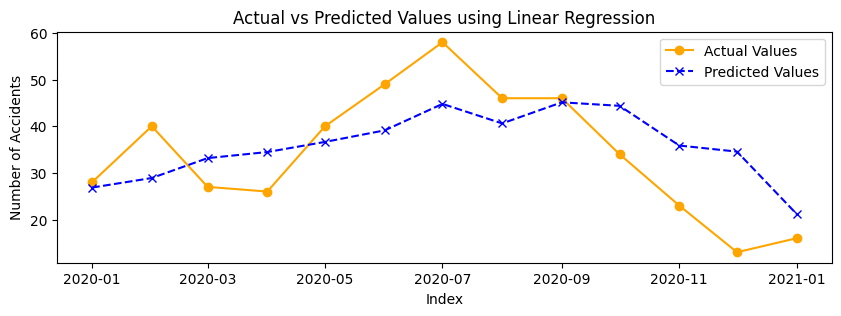

In [171]:
plt.figure(figsize=(10, 3))
plt.plot(results_df['target_test'], label='Actual Values', color='orange', linestyle='-', marker='o')
plt.plot(results_df['predictions'], label='Predicted Values', color='blue', linestyle='--', marker='x')
plt.title('Actual vs Predicted Values using Linear Regression')
plt.xlabel('Index')
plt.ylabel('Number of Accidents')
plt.legend()

plt.savefig('predictions.png')

plt.show()

According to the plot we can conlude that the predicted line averages the actual one, but it doesn't catch the local extreme values.

<a id="3"></a>
## Conclusion
[Back to the top](#0)

In this project:
- We have preprocessed initial data;
- We have used Linear Regression, Decision tree, Random Forest, CatBoostRegressor, LGBMRegressor, Prophet and LSTM models for the regression task;
- We have found optimal hyperparameters using GridSearchCV and RandomizedSearchCV;
- We have found the best model and measure its performance on the test set.

Save the best model for deployment

In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)